Import Python Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Read Dataset

In [2]:
# Read the dataset
file_path = '/content/GDSC_DATASET.csv'
data = pd.read_csv(file_path,nrows=10000)

# Basic info of the Dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   COSMIC_ID                                10000 non-null  int64  
 1   CELL_LINE_NAME                           10000 non-null  object 
 2   TCGA_DESC                                9947 non-null   object 
 3   DRUG_ID                                  10000 non-null  int64  
 4   DRUG_NAME                                10000 non-null  object 
 5   LN_IC50                                  10000 non-null  float64
 6   AUC                                      10000 non-null  float64
 7   Z_SCORE                                  10000 non-null  float64
 8   GDSC Tissue descriptor 1                 9605 non-null   object 
 9   GDSC Tissue descriptor 2                 9605 non-null   object 
 10  Cancer Type (matching TCGA label)        7888 n

In [3]:
#Display First 5 rows from the Dataset
data.head(5)

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [4]:
#Display columns name from the Dataset
data.columns

Index(['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
       'LN_IC50', 'AUC', 'Z_SCORE', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium',
       'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET',
       'TARGET_PATHWAY'],
      dtype='object')

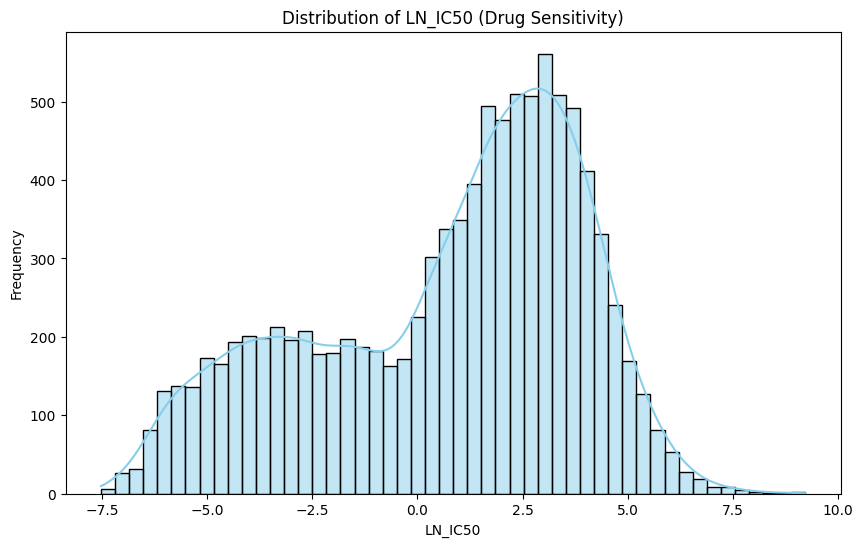

In [5]:
# Plot distribution of LN_IC50
plt.figure(figsize=(10, 6))
sns.histplot(data['LN_IC50'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of LN_IC50 (Drug Sensitivity)')
plt.xlabel('LN_IC50')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Basic statistics of LN_IC50
data['LN_IC50'].describe()

,LN_IC50
count,10000.000000
mean,0.707061
std,3.218968
min,-7.530958
25%,-1.763434
50%,1.548647
75%,3.191143
max,9.229988


Data Pre-processing

In [7]:
#Missing Data

# Missing values in the Dataset
print(data.isnull().sum())

# Drop rows with missing TARGET
clean_data = data.dropna(subset=['TARGET'])

# Fill missing categorical values with the mode value
for col in ['Cancer Type (matching TCGA label)', 'Microsatellite instability Status (MSI)']:
    if col in clean_data.columns:
        clean_data[col].fillna(clean_data[col].mode()[0], inplace=True)

COSMIC_ID                                     0
CELL_LINE_NAME                                0
TCGA_DESC                                    53
DRUG_ID                                       0
DRUG_NAME                                     0
LN_IC50                                       0
AUC                                           0
Z_SCORE                                       0
GDSC Tissue descriptor 1                    395
GDSC Tissue descriptor 2                    395
Cancer Type (matching TCGA label)          2112
Microsatellite instability Status (MSI)     526
Screen Medium                               395
Growth Properties                           395
CNA                                         395
Gene Expression                             395
Methylation                                 395
TARGET                                        0
TARGET_PATHWAY                                0
dtype: int64


<ipython-input-7-e4cac515bc00>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_data[col].fillna(clean_data[col].mode()[0], inplace=True)


In [8]:
#Outlier Detection

# Calculate IQR for LN_IC50
Q1 = clean_data['LN_IC50'].quantile(0.25)
Q3 = clean_data['LN_IC50'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers_before = clean_data[(clean_data['LN_IC50'] < lower_bound) | (clean_data['LN_IC50'] > upper_bound)]

# Print number and percentage of outliers
print(f"Number of outliers in LN_IC50: {outliers_before.shape[0]}")
print(f"Percentage of outliers: {100 * outliers_before.shape[0] / clean_data.shape[0]:.2f}%")

# Apply Winsorization to cap outliers
clean_data['LN_IC50'] = clean_data['LN_IC50'].clip(lower=lower_bound, upper=upper_bound)

Number of outliers in LN_IC50: 0
Percentage of outliers: 0.00%


In [9]:
# One-hot encode categorical features of the relevant columns
categorical_cols = ['DRUG_NAME', 'TARGET_PATHWAY', 'Cancer Type (matching TCGA label)', 'TCGA_DESC',
                    'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 'Microsatellite instability Status (MSI)',
                    'Screen Medium', 'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET']

clean_data = pd.get_dummies(clean_data, columns=categorical_cols, drop_first=True)

# Drop unused columns and define features and target
X = clean_data.drop(['LN_IC50', 'COSMIC_ID', 'CELL_LINE_NAME'], axis=1)
y = clean_data['LN_IC50']

# Select only numerical columns for features
X = X.select_dtypes(include=['number'])

Model Training & Testing

In [10]:
# ----------------- Linear Regression Algorithm------------------
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

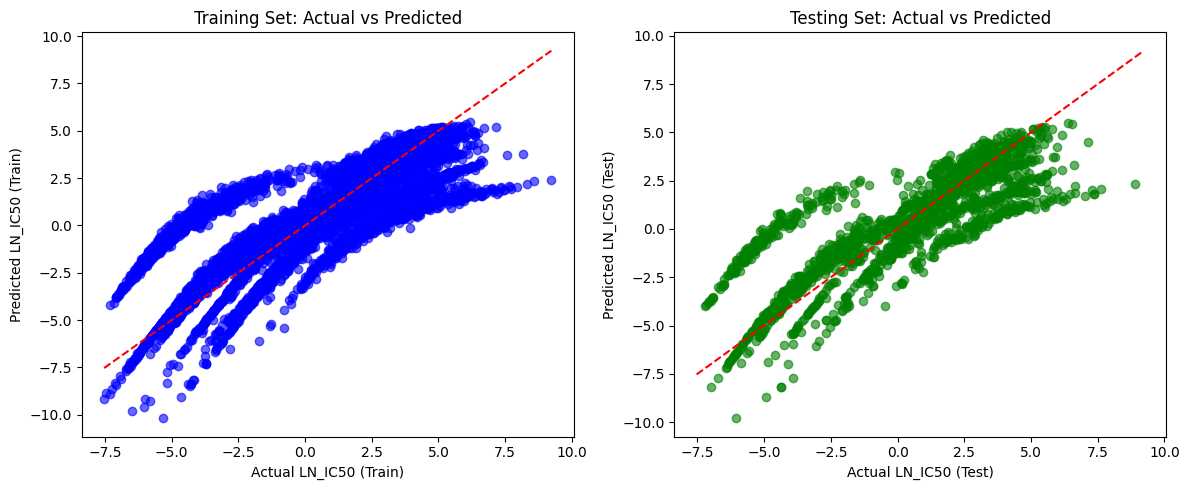

In [11]:
# Predict on train and test sets
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Plot predicted vs actual for training and testing
plt.figure(figsize=(12, 5))

# Training data plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual LN_IC50 (Train)')
plt.ylabel('Predicted LN_IC50 (Train)')
plt.title('Training Set: Actual vs Predicted')

# Testing data plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual LN_IC50 (Test)')
plt.ylabel('Predicted LN_IC50 (Test)')
plt.title('Testing Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

Model Evaluation

In [12]:
# Model evaluation in Test Dataset
r2 = r2_score(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred)
mae= mean_absolute_error(y_test, y_test_pred)

# Print evaluation results
print("\n--- Linear Regression ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


--- Linear Regression ---
R² Score: 0.6875
RMSE: 3.2146
MAE: 1.2406
